In [4]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from chewc.population import msprime_pop
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno, set_bv
from chewc.cross import make_cross

# ==================================================
# ---  simulation_parameters ---
# ==================================================
simulation_parameters = {
    "n_replicates": 3,
    "n_founder_ind": 10,
    "n_loci_per_chr": 1000,
    "n_chr": 5,
    "n_qtl_per_chr": 100,
    "trait_mean": jnp.array([0.0]),
    "trait_var": jnp.array([1.0]),
    "n_generations": 50,
    "population_size": 200,
    "n_select": 20,
    "key": jax.random.PRNGKey(42)
}
# ====

# --- Setup Founder Population and Traits using Parameters ---
key = simulation_parameters["key"]
key, founder_key, sp1_key, sp2_key = jax.random.split(key, 4)

founder_pop, genetic_map = msprime_pop(
    key=founder_key,
    n_ind=simulation_parameters["n_founder_ind"],
    n_loci_per_chr=simulation_parameters["n_loci_per_chr"],
    n_chr=simulation_parameters["n_chr"]
)

# Create SimParam objects for sp1 (Normal) and sp2 (Gamma)
sp1 = SimParam.from_founder_pop(founder_pop, genetic_map)
sp1 = add_trait_a(
    key=sp1_key, founder_pop=founder_pop, sim_param=sp1,
    n_qtl_per_chr=simulation_parameters["n_qtl_per_chr"],
    mean=simulation_parameters["trait_mean"],
    var=simulation_parameters["trait_var"],
    gamma=False
)

# Define the base templates for each simulation group
scenario_templates = [
    {"name_base": "sp1 (Normal)", "sp": sp1, "color": "blue"},
]

# Define the heritabilities you want to test
h2_values_to_test = [0.1, 0.6]

# Dynamically assign colors for different h2 values if you want
# For simplicity, we can just alternate or use a predefined map.
h2_colors = {"0.1": "blue", "0.6": "red"} # Example color mapping




--- Running Simulations for h2 = 0.1 ---
Replicate 1/3 (ABLUP)
  ABLUP Gen 1/20 - Mean BV: -0.2460
  ABLUP Gen 2/20 - Mean BV: 0.7717
  ABLUP Gen 3/20 - Mean BV: 1.5380
  ABLUP Gen 4/20 - Mean BV: 1.8262
  ABLUP Gen 5/20 - Mean BV: 2.7968
  ABLUP Gen 6/20 - Mean BV: 3.7343
  ABLUP Gen 7/20 - Mean BV: 4.3680
  ABLUP Gen 8/20 - Mean BV: 4.5072
  ABLUP Gen 9/20 - Mean BV: 4.6828
  ABLUP Gen 10/20 - Mean BV: 5.0379
  ABLUP Gen 11/20 - Mean BV: 5.2229
  ABLUP Gen 12/20 - Mean BV: 5.3996
  ABLUP Gen 13/20 - Mean BV: 5.8322
  ABLUP Gen 14/20 - Mean BV: 6.3132
  ABLUP Gen 15/20 - Mean BV: 6.7367
  ABLUP Gen 16/20 - Mean BV: 7.0495
  ABLUP Gen 17/20 - Mean BV: 7.1691
  ABLUP Gen 18/20 - Mean BV: 7.3813
  ABLUP Gen 19/20 - Mean BV: 7.4729
  ABLUP Gen 20/20 - Mean BV: 7.8342
Replicate 2/3 (ABLUP)
  ABLUP Gen 1/20 - Mean BV: -0.1545
  ABLUP Gen 2/20 - Mean BV: 1.0347
  ABLUP Gen 3/20 - Mean BV: 1.8239
  ABLUP Gen 4/20 - Mean BV: 2.8284
  ABLUP Gen 5/20 - Mean BV: 3.7019
  ABLUP Gen 6/20 - Mean BV

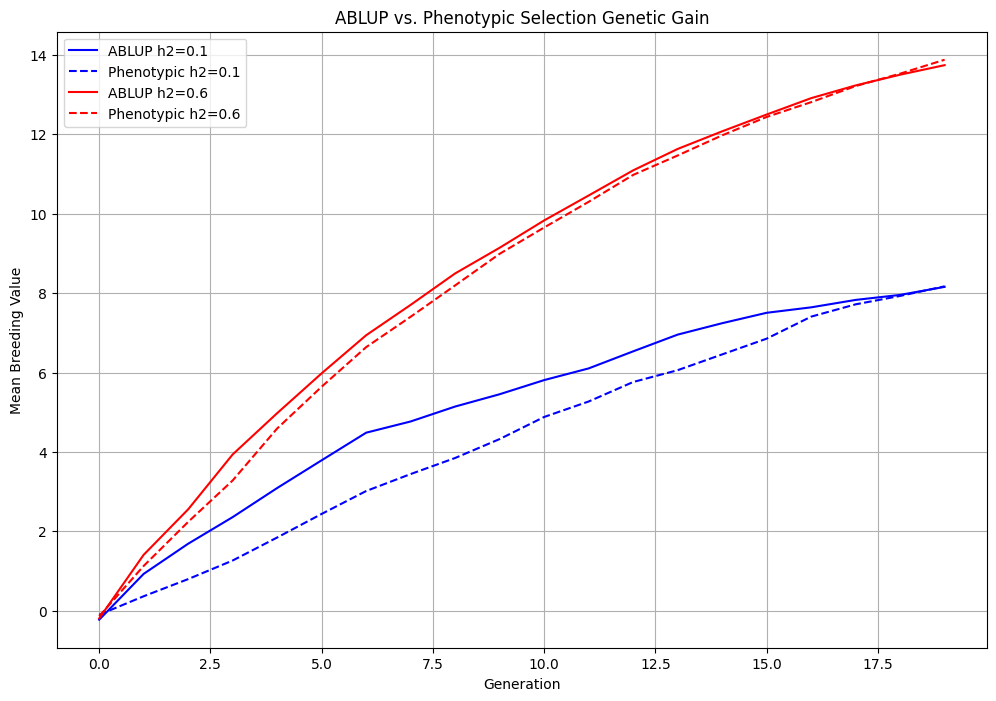

In [9]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from jax import jit
from chewc.population import (
    msprime_pop,
    combine_populations,
    subset_population,
    Population,
)
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno
from chewc.cross import make_cross
from chewc.predict import PredictionResults

# ==================================================
# --- Simulation Parameters ---
# ==================================================
simulation_parameters = {
    "n_replicates": 3,
    "n_founder_ind": 10,
    "n_loci_per_chr": 1000,
    "n_chr": 5,
    "n_qtl_per_chr": 100,
    "trait_mean": jnp.array([0.0]),
    "trait_var": jnp.array([1.0]),
    "n_generations": 20,  # --- CHANGED TO 20 ---
    "population_size": 200,
    "n_select": 20,
    "key": jax.random.PRNGKey(42),
}

# --- Setup Founder Population and Traits ---
key = simulation_parameters["key"]
key, founder_key, sp1_key = jax.random.split(key, 3)

founder_pop, genetic_map = msprime_pop(
    key=founder_key,
    n_ind=simulation_parameters["n_founder_ind"],
    n_loci_per_chr=simulation_parameters["n_loci_per_chr"],
    n_chr=simulation_parameters["n_chr"],
)

sp1 = SimParam.from_founder_pop(founder_pop, genetic_map)
sp1 = add_trait_a(
    key=sp1_key,
    founder_pop=founder_pop,
    sim_param=sp1,
    n_qtl_per_chr=simulation_parameters["n_qtl_per_chr"],
    mean=simulation_parameters["trait_mean"],
    var=simulation_parameters["trait_var"],
)

h2_values_to_test = [0.1, 0.6]

# ==================================================
# --- Core ABLUP Functions (Corrected) ---
# ==================================================

def calc_a_inverse_matrix_pedigree_non_jit(pop: Population) -> jnp.ndarray:
    n_ind = pop.nInd
    mother_iids = jnp.asarray(pop.mother)
    father_iids = jnp.asarray(pop.father)
    id_to_iid = {int(pub_id): int(iid) for pub_id, iid in zip(pop.id, pop.iid)}
    unknown_parent_iid = -1
    A_inv = jnp.zeros((n_ind, n_ind))
    for i in range(n_ind):
        sire_pub_id, dam_pub_id = father_iids[i], mother_iids[i]
        s = id_to_iid.get(int(sire_pub_id), unknown_parent_iid)
        d = id_to_iid.get(int(dam_pub_id), unknown_parent_iid)
        if s == unknown_parent_iid and d == unknown_parent_iid:
            A_inv = A_inv.at[i, i].add(1.0)
        elif s != unknown_parent_iid and d == unknown_parent_iid:
            A_inv = A_inv.at[i, i].add(4/3).at[s, s].add(1/3).at[i, s].add(-2/3).at[s, i].add(-2/3)
        elif s == unknown_parent_iid and d != unknown_parent_iid:
            A_inv = A_inv.at[i, i].add(4/3).at[d, d].add(1/3).at[i, d].add(-2/3).at[d, i].add(-2/3)
        else:
            A_inv = A_inv.at[i, i].add(2.0).at[s, s].add(0.5).at[d, d].add(0.5).at[s, d].add(0.5).at[d, s].add(0.5).at[i, s].add(-1.0).at[s, i].add(-1.0).at[i, d].add(-1.0).at[d, i].add(-1.0)
    return A_inv

@partial(jit, static_argnames=('n_ind',))
def _mme_solver(y_full, train_mask, K_inv, h2, n_ind):
    X = jnp.ones((n_ind, 1))
    Z = jnp.identity(n_ind)
    W = jnp.diag(train_mask.astype(jnp.float32))
    alpha = (1.0 - h2) / (h2 + 1e-9)
    XTWX = X.T @ W @ X
    XTWZ = X.T @ W @ Z
    ZTWX = Z.T @ W @ X
    ZTWZ_plus_alpha_Kinv = (Z.T @ W @ Z) + alpha * K_inv
    lhs_top = jnp.hstack([XTWX, XTWZ])
    lhs_bottom = jnp.hstack([ZTWX, ZTWZ_plus_alpha_Kinv])
    lhs = jnp.vstack([lhs_top, lhs_bottom])
    XTWy = X.T @ W @ y_full
    ZTWy = Z.T @ W @ y_full
    rhs = jnp.concatenate([XTWy.flatten(), ZTWy.flatten()])
    solutions = jnp.linalg.solve(lhs, rhs)
    return solutions[1:]

def run_ablup_prediction(pop: Population, h2: float, trait_idx: int = 0) -> PredictionResults:
    pheno = pop.pheno[:, trait_idx]
    train_mask = ~jnp.isnan(pheno)
    y_full = jnp.nan_to_num(pheno)
    K_inv = calc_a_inverse_matrix_pedigree_non_jit(pop)
    all_ebv = _mme_solver(y_full, train_mask, K_inv, h2, pop.nInd)
    return PredictionResults(ids=pop.id, ebv=all_ebv.reshape(-1, 1))

# ==================================================
# --- Simulation Functions ---
# ==================================================

def run_ablup_simulation(h2, key):
    """Runs a single replicate of the ABLUP simulation."""
    key, pheno_key = jax.random.split(key)
    pop = set_pheno(pheno_key, founder_pop, sp1.traits, sp1.ploidy, h2=jnp.array([h2]))
    genetic_gain_tracker = []
    for gen in range(simulation_parameters["n_generations"]):
        prediction_results = run_ablup_prediction(pop, h2=h2)
        pop = pop.replace(ebv=prediction_results.ebv)
        n_select_actual = min(pop.nInd, simulation_parameters["n_select"])
        top_indices = jnp.argsort(pop.ebv.flatten())[-n_select_actual:]
        selected_pop = subset_population(pop, top_indices)
        key, mother_key, father_key, cross_key = jax.random.split(key, 4)
        mother_iids = jax.random.choice(mother_key, selected_pop.iid, shape=(simulation_parameters["population_size"],))
        father_iids = jax.random.choice(father_key, selected_pop.iid, shape=(simulation_parameters["population_size"],))
        cross_plan = jnp.vstack([mother_iids, father_iids]).T
        progeny_pop = make_cross(key=cross_key, pop=selected_pop, cross_plan=cross_plan, sp=sp1, next_id_start=pop.id.max() + 1)
        key, pheno_key = jax.random.split(key)
        progeny_pop_pheno = set_pheno(pheno_key, progeny_pop, sp1.traits, sp1.ploidy, h2=jnp.array([h2]))
        pop = combine_populations(pop, progeny_pop_pheno)
        mean_bv_current_gen = jnp.mean(progeny_pop_pheno.bv)
        genetic_gain_tracker.append(mean_bv_current_gen)
        print(f"  ABLUP Gen {gen+1}/{simulation_parameters['n_generations']} - Mean BV: {mean_bv_current_gen:.4f}")
    return genetic_gain_tracker

def run_phenotypic_selection_simulation(h2, key):
    """Runs a single replicate of the phenotypic selection simulation."""
    key, pheno_key = jax.random.split(key)
    # Start with a fresh copy of the founder population for each replicate
    pop = set_pheno(pheno_key, founder_pop, sp1.traits, sp1.ploidy, h2=jnp.array([h2]))
    genetic_gain_tracker = []
    
    # In phenotypic selection, we only need the current generation for selection
    current_gen_pop = pop
    
    for gen in range(simulation_parameters["n_generations"]):
        # 1. Selection based on phenotype
        n_select_actual = min(current_gen_pop.nInd, simulation_parameters["n_select"])
        top_indices = jnp.argsort(current_gen_pop.pheno.flatten())[-n_select_actual:]
        selected_pop = subset_population(current_gen_pop, top_indices)

        # 2. Mating
        key, mother_key, father_key, cross_key = jax.random.split(key, 4)
        mother_iids = jax.random.choice(mother_key, selected_pop.iid, shape=(simulation_parameters["population_size"],))
        father_iids = jax.random.choice(father_key, selected_pop.iid, shape=(simulation_parameters["population_size"],))
        cross_plan = jnp.vstack([mother_iids, father_iids]).T
        
        progeny_pop = make_cross(key=cross_key, pop=selected_pop, cross_plan=cross_plan, sp=sp1, next_id_start=pop.id.max() + 1)
        
        # 3. Phenotype new generation and update population for the next cycle
        key, pheno_key = jax.random.split(key)
        progeny_pop_pheno = set_pheno(pheno_key, progeny_pop, sp1.traits, sp1.ploidy, h2=jnp.array([h2]))
        
        # Update the overall population history (for potential analysis, though not used in selection)
        pop = combine_populations(pop, progeny_pop_pheno)
        # The next selection round is only on the newly created animals
        current_gen_pop = progeny_pop_pheno

        # 4. Track metrics
        mean_bv_current_gen = jnp.mean(progeny_pop_pheno.bv)
        genetic_gain_tracker.append(mean_bv_current_gen)
        print(f"  Phenotypic Gen {gen+1}/{simulation_parameters['n_generations']} - Mean BV: {mean_bv_current_gen:.4f}")
        
    return genetic_gain_tracker

# --- Run Simulation and Plot ---
all_results = {}
for h2 in h2_values_to_test:
    print(f"\n--- Running Simulations for h2 = {h2} ---")
    
    # ABLUP Replicates
    ablup_replicate_gains = []
    for i in range(simulation_parameters["n_replicates"]):
        print(f"Replicate {i+1}/{simulation_parameters['n_replicates']} (ABLUP)")
        key, rep_key = jax.random.split(key)
        gains = run_ablup_simulation(h2, rep_key)
        ablup_replicate_gains.append(gains)
    all_results[f'ABLUP h2={h2}'] = jnp.mean(jnp.array(ablup_replicate_gains), axis=0)
    
    # Phenotypic Selection Replicates
    phenotypic_replicate_gains = []
    for i in range(simulation_parameters["n_replicates"]):
        print(f"Replicate {i+1}/{simulation_parameters['n_replicates']} (Phenotypic)")
        key, rep_key = jax.random.split(key)
        gains = run_phenotypic_selection_simulation(h2, rep_key)
        phenotypic_replicate_gains.append(gains)
    all_results[f'Phenotypic h2={h2}'] = jnp.mean(jnp.array(phenotypic_replicate_gains), axis=0)

# Plotting
plt.figure(figsize=(12, 8))
colors = {'0.1': 'blue', '0.6': 'red'}
for name, results in all_results.items():
    h2_val = name.split('=')[-1]
    color = colors[h2_val]
    linestyle = '--' if 'Phenotypic' in name else '-'
    plt.plot(results, label=name, color=color, linestyle=linestyle)

plt.title('ABLUP vs. Phenotypic Selection Genetic Gain')
plt.xlabel('Generation')
plt.ylabel('Mean Breeding Value')
plt.legend()
plt.grid(True)
plt.show()

/mnt/c/Users/cltng/gdrive/chewc/chewc/population.py:570: UserWarning: Small founder population size (10) with enforce_founder_maf=True may result in few usable markers. Consider increasing n_ind or setting enforce_founder_maf=False.
  warnings.warn(



--- Running Simulations for h2 = 0.1 ---
  Replicate 1/3 (ABLUP)
  Replicate 2/3 (ABLUP)
  Replicate 3/3 (ABLUP)
  Replicate 1/3 (Phenotypic)
  Replicate 2/3 (Phenotypic)
  Replicate 3/3 (Phenotypic)

--- Running Simulations for h2 = 0.6 ---
  Replicate 1/3 (ABLUP)
  Replicate 2/3 (ABLUP)
  Replicate 3/3 (ABLUP)
  Replicate 1/3 (Phenotypic)
  Replicate 2/3 (Phenotypic)
  Replicate 3/3 (Phenotypic)


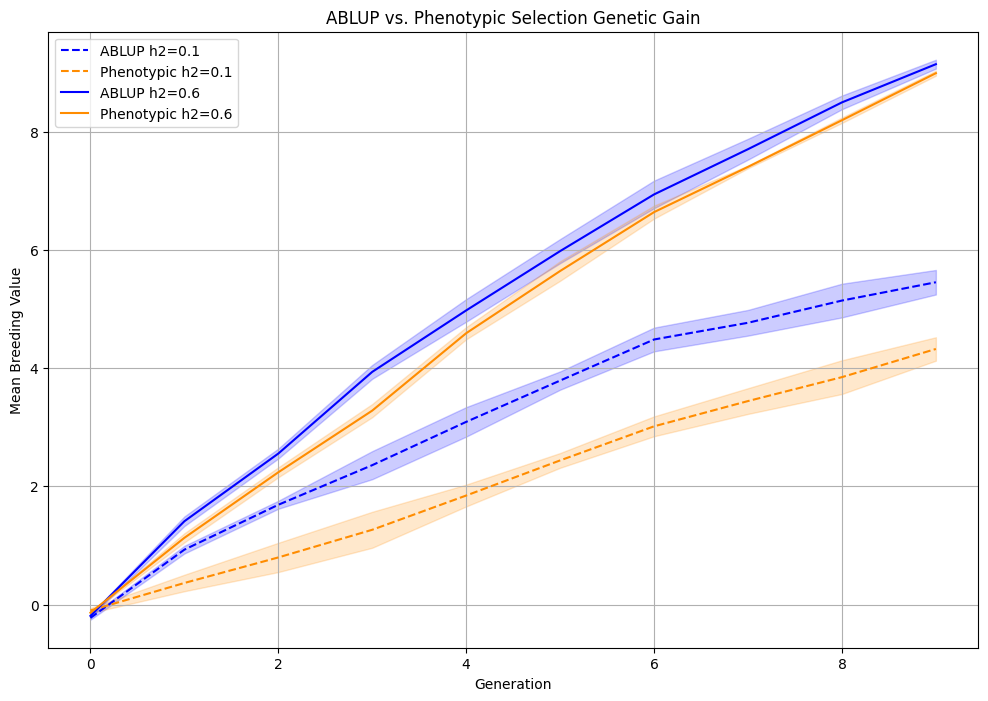

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from jax import jit
from chewc.population import (
    msprime_pop,
    combine_populations,
    subset_population,
    Population,
)
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno
from chewc.cross import make_cross
from chewc.predict import PredictionResults

# ==================================================
# --- Simulation Parameters ---
# ==================================================
simulation_parameters = {
    "n_replicates": 3,               # --- CHANGED TO 10 ---
    "n_founder_ind": 10,
    "n_loci_per_chr": 1000,
    "n_chr": 5,
    "n_qtl_per_chr": 100,
    "trait_mean": jnp.array([0.0]),
    "trait_var": jnp.array([1.0]),
    "n_generations": 10,              # --- CHANGED TO 30 ---
    "population_size": 200,
    "n_select": 20,
    "key": jax.random.PRNGKey(42),
}

# --- Setup Founder Population and Traits ---
key = simulation_parameters["key"]
key, founder_key, sp1_key = jax.random.split(key, 3)

founder_pop, genetic_map = msprime_pop(
    key=founder_key,
    n_ind=simulation_parameters["n_founder_ind"],
    n_loci_per_chr=simulation_parameters["n_loci_per_chr"],
    n_chr=simulation_parameters["n_chr"],
)

sp1 = SimParam.from_founder_pop(founder_pop, genetic_map)
sp1 = add_trait_a(
    key=sp1_key,
    founder_pop=founder_pop,
    sim_param=sp1,
    n_qtl_per_chr=simulation_parameters["n_qtl_per_chr"],
    mean=simulation_parameters["trait_mean"],
    var=simulation_parameters["trait_var"],
)

h2_values_to_test = [0.1, 0.6]

# ==================================================
# --- Core ABLUP Functions (Corrected) ---
# ==================================================

def calc_a_inverse_matrix_pedigree_non_jit(pop: Population) -> jnp.ndarray:
    n_ind = pop.nInd
    mother_iids = jnp.asarray(pop.mother)
    father_iids = jnp.asarray(pop.father)
    id_to_iid = {int(pub_id): int(iid) for pub_id, iid in zip(pop.id, pop.iid)}
    unknown_parent_iid = -1
    A_inv = jnp.zeros((n_ind, n_ind))
    for i in range(n_ind):
        sire_pub_id, dam_pub_id = father_iids[i], mother_iids[i]
        s = id_to_iid.get(int(sire_pub_id), unknown_parent_iid)
        d = id_to_iid.get(int(dam_pub_id), unknown_parent_iid)
        if s == unknown_parent_iid and d == unknown_parent_iid:
            A_inv = A_inv.at[i, i].add(1.0)
        elif s != unknown_parent_iid and d == unknown_parent_iid:
            A_inv = A_inv.at[i, i].add(4/3).at[s, s].add(1/3).at[i, s].add(-2/3).at[s, i].add(-2/3)
        elif s == unknown_parent_iid and d != unknown_parent_iid:
            A_inv = A_inv.at[i, i].add(4/3).at[d, d].add(1/3).at[i, d].add(-2/3).at[d, i].add(-2/3)
        else:
            A_inv = A_inv.at[i, i].add(2.0).at[s, s].add(0.5).at[d, d].add(0.5).at[s, d].add(0.5).at[d, s].add(0.5).at[i, s].add(-1.0).at[s, i].add(-1.0).at[i, d].add(-1.0).at[d, i].add(-1.0)
    return A_inv

@partial(jit, static_argnames=('n_ind',))
def _mme_solver(y_full, train_mask, K_inv, h2, n_ind):
    X = jnp.ones((n_ind, 1))
    Z = jnp.identity(n_ind)
    W = jnp.diag(train_mask.astype(jnp.float32))
    alpha = (1.0 - h2) / (h2 + 1e-9)
    XTWX = X.T @ W @ X
    XTWZ = X.T @ W @ Z
    ZTWX = Z.T @ W @ X
    ZTWZ_plus_alpha_Kinv = (Z.T @ W @ Z) + alpha * K_inv
    lhs_top = jnp.hstack([XTWX, XTWZ])
    lhs_bottom = jnp.hstack([ZTWX, ZTWZ_plus_alpha_Kinv])
    lhs = jnp.vstack([lhs_top, lhs_bottom])
    XTWy = X.T @ W @ y_full
    ZTWy = Z.T @ W @ y_full
    rhs = jnp.concatenate([XTWy.flatten(), ZTWy.flatten()])
    solutions = jnp.linalg.solve(lhs, rhs)
    return solutions[1:]

def run_ablup_prediction(pop: Population, h2: float, trait_idx: int = 0) -> PredictionResults:
    pheno = pop.pheno[:, trait_idx]
    train_mask = ~jnp.isnan(pheno)
    y_full = jnp.nan_to_num(pheno)
    K_inv = calc_a_inverse_matrix_pedigree_non_jit(pop)
    all_ebv = _mme_solver(y_full, train_mask, K_inv, h2, pop.nInd)
    return PredictionResults(ids=pop.id, ebv=all_ebv.reshape(-1, 1))

# ==================================================
# --- Simulation Functions ---
# ==================================================

def run_ablup_simulation(h2, key):
    """Runs a single replicate of the ABLUP simulation."""
    key, pheno_key = jax.random.split(key)
    pop = set_pheno(pheno_key, founder_pop, sp1.traits, sp1.ploidy, h2=jnp.array([h2]))
    genetic_gain_tracker = []
    for gen in range(simulation_parameters["n_generations"]):
        prediction_results = run_ablup_prediction(pop, h2=h2)
        pop = pop.replace(ebv=prediction_results.ebv)
        n_select_actual = min(pop.nInd, simulation_parameters["n_select"])
        top_indices = jnp.argsort(pop.ebv.flatten())[-n_select_actual:]
        selected_pop = subset_population(pop, top_indices)
        key, mother_key, father_key, cross_key = jax.random.split(key, 4)
        mother_iids = jax.random.choice(mother_key, selected_pop.iid, shape=(simulation_parameters["population_size"],))
        father_iids = jax.random.choice(father_key, selected_pop.iid, shape=(simulation_parameters["population_size"],))
        cross_plan = jnp.vstack([mother_iids, father_iids]).T
        progeny_pop = make_cross(key=cross_key, pop=selected_pop, cross_plan=cross_plan, sp=sp1, next_id_start=pop.id.max() + 1)
        key, pheno_key = jax.random.split(key)
        progeny_pop_pheno = set_pheno(pheno_key, progeny_pop, sp1.traits, sp1.ploidy, h2=jnp.array([h2]))
        pop = combine_populations(pop, progeny_pop_pheno)
        mean_bv_current_gen = jnp.mean(progeny_pop_pheno.bv)
        genetic_gain_tracker.append(mean_bv_current_gen)
    return genetic_gain_tracker

def run_phenotypic_selection_simulation(h2, key):
    """Runs a single replicate of the phenotypic selection simulation."""
    key, pheno_key = jax.random.split(key)
    pop = set_pheno(pheno_key, founder_pop, sp1.traits, sp1.ploidy, h2=jnp.array([h2]))
    genetic_gain_tracker = []
    current_gen_pop = pop
    for gen in range(simulation_parameters["n_generations"]):
        n_select_actual = min(current_gen_pop.nInd, simulation_parameters["n_select"])
        top_indices = jnp.argsort(current_gen_pop.pheno.flatten())[-n_select_actual:]
        selected_pop = subset_population(current_gen_pop, top_indices)
        key, mother_key, father_key, cross_key = jax.random.split(key, 4)
        mother_iids = jax.random.choice(mother_key, selected_pop.iid, shape=(simulation_parameters["population_size"],))
        father_iids = jax.random.choice(father_key, selected_pop.iid, shape=(simulation_parameters["population_size"],))
        cross_plan = jnp.vstack([mother_iids, father_iids]).T
        progeny_pop = make_cross(key=cross_key, pop=selected_pop, cross_plan=cross_plan, sp=sp1, next_id_start=pop.id.max() + 1)
        key, pheno_key = jax.random.split(key)
        progeny_pop_pheno = set_pheno(pheno_key, progeny_pop, sp1.traits, sp1.ploidy, h2=jnp.array([h2]))
        pop = combine_populations(pop, progeny_pop_pheno)
        current_gen_pop = progeny_pop_pheno
        mean_bv_current_gen = jnp.mean(progeny_pop_pheno.bv)
        genetic_gain_tracker.append(mean_bv_current_gen)
    return genetic_gain_tracker

# --- Run Simulation and Plot ---
all_results = {}
for h2 in h2_values_to_test:
    print(f"\n--- Running Simulations for h2 = {h2} ---")
    
    # --- ABLUP Replicates ---
    ablup_replicate_gains = []
    for i in range(simulation_parameters["n_replicates"]):
        print(f"  Replicate {i+1}/{simulation_parameters['n_replicates']} (ABLUP)")
        key, rep_key = jax.random.split(key)
        gains = run_ablup_simulation(h2, rep_key)
        ablup_replicate_gains.append(gains)
    # Store all replicate data for CI calculation
    all_results[f'ABLUP h2={h2}'] = jnp.array(ablup_replicate_gains)
    
    # --- Phenotypic Selection Replicates ---
    phenotypic_replicate_gains = []
    for i in range(simulation_parameters["n_replicates"]):
        print(f"  Replicate {i+1}/{simulation_parameters['n_replicates']} (Phenotypic)")
        key, rep_key = jax.random.split(key)
        gains = run_phenotypic_selection_simulation(h2, rep_key)
        phenotypic_replicate_gains.append(gains)
    # Store all replicate data for CI calculation
    all_results[f'Phenotypic h2={h2}'] = jnp.array(phenotypic_replicate_gains)

# --- Plotting ---
plt.figure(figsize=(12, 8))
# --- UPDATED COLORS AND STYLES ---
colors = {"ABLUP": "blue", "Phenotypic": "darkorange"}
linestyles = {"0.1": "--", "0.6": "-"}

for name, results_array in all_results.items():
    # Calculate mean, standard error for confidence interval
    mean_gain = jnp.mean(results_array, axis=0)
    std_err = jnp.std(results_array, axis=0) / jnp.sqrt(simulation_parameters["n_replicates"])
    
    # Determine plot properties from the name
    method = "ABLUP" if "ABLUP" in name else "Phenotypic"
    h2_val = name.split('=')[-1]
    
    # Plot the mean genetic gain
    plt.plot(mean_gain, label=name, color=colors[method], linestyle=linestyles[h2_val])
    
    # Plot the confidence interval
    plt.fill_between(
        range(simulation_parameters["n_generations"]),
        mean_gain - std_err,
        mean_gain + std_err,
        color=colors[method],
        alpha=0.2
    )

plt.title('ABLUP vs. Phenotypic Selection Genetic Gain')
plt.xlabel('Generation')
plt.ylabel('Mean Breeding Value')
plt.legend()
plt.grid(True)
plt.show()


--- Running APY-GBLUP Simulation ---
  APY-GBLUP Gen 1/10
  APY-GBLUP Gen 2/10
  APY-GBLUP Gen 3/10
  APY-GBLUP Gen 4/10
  APY-GBLUP Gen 5/10
  APY-GBLUP Gen 6/10
  APY-GBLUP Gen 7/10
  APY-GBLUP Gen 8/10
  APY-GBLUP Gen 9/10
  APY-GBLUP Gen 10/10


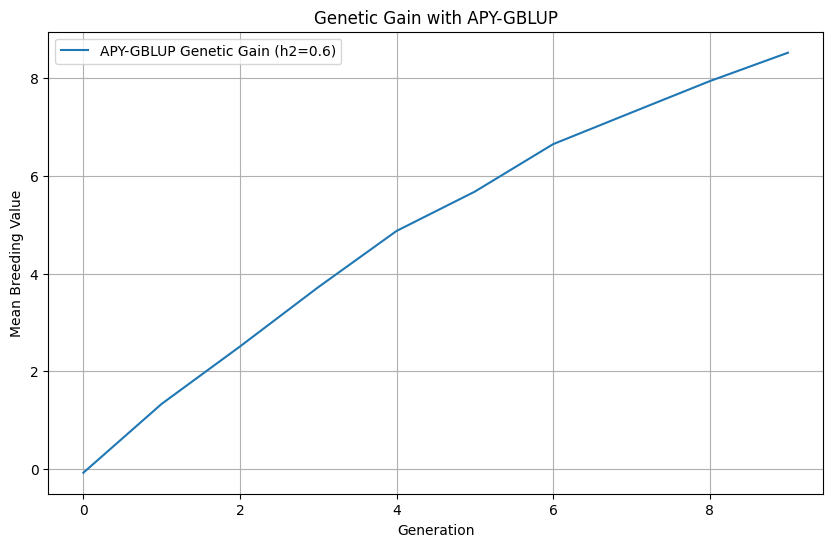

CPU times: user 39.7 s, sys: 1.5 s, total: 41.2 s
Wall time: 12.4 s


In [17]:
%%time
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from jax import jit
from chewc.population import (
    msprime_pop,
    combine_populations,
    subset_population,
    Population,
)
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno
from chewc.cross import make_cross
from typing import Optional, Dict
from flax.struct import dataclass as flax_dataclass

@flax_dataclass(frozen=True)
class PredictionResults:
    """A container for the results of a prediction."""
    ids: jnp.ndarray
    ebv: jnp.ndarray
    pev: Optional[jnp.ndarray] = None
    reliability: Optional[jnp.ndarray] = None
    fixed_effects: Optional[jnp.ndarray] = None
    h2_used: Optional[float] = None
    var_components: Optional[Dict] = None

# ==================================================
# --- Simulation Parameters ---
# ==================================================
simulation_parameters = {
    "n_replicates": 3,
    "n_founder_ind": 10,
    "n_loci_per_chr": 1000,
    "n_chr": 5,
    "n_qtl_per_chr": 100,
    "trait_mean": jnp.array([0.0]),
    "trait_var": jnp.array([1.0]),
    "n_generations": 10,
    "population_size": 200,
    "n_select": 20,
    "n_core_animals": 50,  # --- NEW: Size of the 'proven' group for APY ---
    "key": jax.random.PRNGKey(42),
}

# --- Setup Founder Population and Traits ---
key = simulation_parameters["key"]
key, founder_key, sp1_key = jax.random.split(key, 3)
founder_pop, genetic_map = msprime_pop(
    key=founder_key,
    n_ind=simulation_parameters["n_founder_ind"],
    n_loci_per_chr=simulation_parameters["n_loci_per_chr"],
    n_chr=simulation_parameters["n_chr"],
)
sp1 = SimParam.from_founder_pop(founder_pop, genetic_map)
sp1 = add_trait_a(
    key=sp1_key, founder_pop=founder_pop, sim_param=sp1,
    n_qtl_per_chr=simulation_parameters["n_qtl_per_chr"],
    mean=simulation_parameters["trait_mean"],
    var=simulation_parameters["trait_var"],
)
h2_values_to_test = [0.1, 0.6]

# ==================================================
# --- JAX-Native APY GBLUP Functions ---
# ==================================================

@partial(jit, static_argnames=('n_proven', 'n_young'))
def apy_inverse(
    Z_proven: jnp.ndarray, Z_young: jnp.ndarray, q: float, n_proven: int, n_young: int
) -> jnp.ndarray:
    """JIT-compatible APY G-inverse calculation."""
    G_pp = (Z_proven @ Z_proven.T) / q
    G_pp_inv = jnp.linalg.inv(G_pp)
    G_yp = (Z_young @ Z_proven.T) / q
    g_ii_diag = jnp.sum(Z_young * Z_young, axis=1) / q
    T = G_yp @ G_pp_inv
    correction_diag = jnp.sum(T * G_yp, axis=1)
    m_diag = g_ii_diag - correction_diag
    M_inv_diag = 1.0 / m_diag
    top_left = G_pp_inv + T.T @ jnp.diag(M_inv_diag) @ T
    top_right = -T.T @ jnp.diag(M_inv_diag)
    bottom_left = -jnp.diag(M_inv_diag) @ T
    bottom_right = jnp.diag(M_inv_diag)
    return jnp.block([[top_left, top_right], [bottom_left, bottom_right]])

@partial(jit, static_argnames=('n_ind',))
def _mme_solver(y_full, train_mask, K_inv, h2, n_ind):
    """JIT-compiled MME solver."""
    X, Z = jnp.ones((n_ind, 1)), jnp.identity(n_ind)
    W = jnp.diag(train_mask.astype(jnp.float32))
    alpha = (1.0 - h2) / (h2 + 1e-9)
    XTWX, XTWZ, ZTWX = X.T @ W @ X, X.T @ W @ Z, Z.T @ W @ X
    ZTWZ_plus_alpha_Kinv = (Z.T @ W @ Z) + alpha * K_inv
    lhs = jnp.vstack([jnp.hstack([XTWX, XTWZ]), jnp.hstack([ZTWX, ZTWZ_plus_alpha_Kinv])])
    rhs = jnp.concatenate([(X.T @ W @ y_full).flatten(), (Z.T @ W @ y_full).flatten()])
    return jnp.linalg.solve(lhs, rhs)[1:]

def run_apy_gblup_prediction(pop: Population, h2: float, n_core: int, trait_idx: int = 0) -> PredictionResults:
    """Orchestrates the APY-GBLUP prediction pipeline."""
    # 1. Define proven (core) and young (non-core) animals
    # For simplicity, we take the oldest animals as proven.
    n_proven = min(pop.nInd, n_core)
    n_young = pop.nInd - n_proven
    
    proven_indices = jnp.arange(n_proven)
    young_indices = jnp.arange(n_proven, pop.nInd)
    
    # 2. Prepare Genotype Matrices
    dosages = pop.dosage
    p = jnp.mean(dosages, axis=0) / 2.0
    Z = dosages - 2 * p
    q = 2 * jnp.sum(p * (1 - p))
    
    Z_proven = Z[proven_indices, :]
    Z_young = Z[young_indices, :]

    # 3. Calculate APY G-inverse (JIT-compiled)
    G_inv_approx = apy_inverse(Z_proven, Z_young, q, n_proven, n_young)
    
    # 4. Solve MME (JIT-compiled)
    pheno = pop.pheno[:, trait_idx]
    train_mask = ~jnp.isnan(pheno)
    y_full = jnp.nan_to_num(pheno)
    all_ebv = _mme_solver(y_full, train_mask, G_inv_approx, h2, pop.nInd)
    
    return PredictionResults(ids=pop.id, ebv=all_ebv.reshape(-1, 1))

# ==================================================
# --- Simulation Functions ---
# ==================================================

def run_apy_gblup_simulation(h2, key):
    """Runs a single replicate of the APY-GBLUP simulation."""
    key, pheno_key = jax.random.split(key)
    pop = set_pheno(pheno_key, founder_pop, sp1.traits, sp1.ploidy, h2=jnp.array([h2]))
    genetic_gain_tracker = []
    
    for gen in range(simulation_parameters["n_generations"]):
        print(f"  APY-GBLUP Gen {gen+1}/{simulation_parameters['n_generations']}")
        prediction_results = run_apy_gblup_prediction(
            pop, h2=h2, n_core=simulation_parameters["n_core_animals"]
        )
        pop = pop.replace(ebv=prediction_results.ebv)
        
        n_select_actual = min(pop.nInd, simulation_parameters["n_select"])
        top_indices = jnp.argsort(pop.ebv.flatten())[-n_select_actual:]
        selected_pop = subset_population(pop, top_indices)
        
        key, mother_key, father_key, cross_key = jax.random.split(key, 4)
        progeny_pop = make_cross(
            key=cross_key,
            pop=selected_pop,
            cross_plan=jnp.vstack([
                jax.random.choice(mother_key, selected_pop.iid, shape=(simulation_parameters["population_size"],)),
                jax.random.choice(father_key, selected_pop.iid, shape=(simulation_parameters["population_size"],))
            ]).T,
            sp=sp1,
            next_id_start=pop.id.max() + 1
        )
        
        key, pheno_key = jax.random.split(key)
        progeny_pop_pheno = set_pheno(pheno_key, progeny_pop, sp1.traits, sp1.ploidy, h2=jnp.array([h2]))
        pop = combine_populations(pop, progeny_pop_pheno)
        
        genetic_gain_tracker.append(jnp.mean(progeny_pop_pheno.bv))
        
    return genetic_gain_tracker

# Note: The phenotypic simulation function is omitted for brevity but would be identical to the previous version.

# --- Main Execution Block ---
# This part can be expanded to run and plot both APY-GBLUP and phenotypic selection as before.
print("\n--- Running APY-GBLUP Simulation ---")
key, sim_key = jax.random.split(key)
gains = run_apy_gblup_simulation(h2=0.6, key=sim_key)

plt.figure(figsize=(10, 6))
plt.plot(gains, label='APY-GBLUP Genetic Gain (h2=0.6)')
plt.title('Genetic Gain with APY-GBLUP')
plt.xlabel('Generation')
plt.ylabel('Mean Breeding Value')
plt.legend()
plt.grid(True)
plt.show()